**RIESGO DE CRÉDITO**

El proyecto se va a dividir en 2 partes. La primera parte se crearán modelos de Machine Learning donde se calcula la probabilidad de que un cliente no cumpla con sus obligaciones crediticias (PD o Probability of default/probabilidad de incumplimiento) y la segunda parte será donde entren en juego los Algoritmos Genéticos con los que se hará una optimización de la pérdida esperada de la entidad.

## *Análisis exploratorio de los datos* (EDA)

Empezamos importando las librerías necesarias

In [1]:
!pip install xgboost
!pip install imblearn
!pip install scikit-learn==1.2


In [2]:
import os
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_auc_score, accuracy_score, precision_score, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import StackingClassifier

Cargamos la base de datos con la que se va a trabajar

In [3]:
riesgo=pd.read_csv('credit-g.csv',sep=';')
riesgo

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,...,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,...,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,...,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,...,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,...,'no known property',53,none,'for free',2,skilled,2,none,yes,bad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,'no checking',12,'existing paid',furniture/equipment,1736,'<100','4<=X<7',3,'female div/dep/mar',none,...,'real estate',31,none,own,1,'unskilled resident',1,none,yes,good
996,'<0',30,'existing paid','used car',3857,'<100','1<=X<4',4,'male div/sep',none,...,'life insurance',40,none,own,1,'high qualif/self emp/mgmt',1,yes,yes,good
997,'no checking',12,'existing paid',radio/tv,804,'<100','>=7',4,'male single',none,...,car,38,none,own,1,skilled,1,none,yes,good
998,'<0',45,'existing paid',radio/tv,1845,'<100','1<=X<4',4,'male single',none,...,'no known property',23,none,'for free',1,skilled,1,yes,yes,bad


Miramos de que tipo son los datos con los que se va a trabajar 

In [4]:
riesgo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   checking_status         1000 non-null   object
 1   duration                1000 non-null   int64 
 2   credit_history          1000 non-null   object
 3   purpose                 1000 non-null   object
 4   credit_amount           1000 non-null   int64 
 5   savings_status          1000 non-null   object
 6   employment              1000 non-null   object
 7   installment_commitment  1000 non-null   int64 
 8   personal_status         1000 non-null   object
 9   other_parties           1000 non-null   object
 10  residence_since         1000 non-null   int64 
 11  property_magnitude      1000 non-null   object
 12  age                     1000 non-null   int64 
 13  other_payment_plans     1000 non-null   object
 14  housing                 1000 non-null   object
 15  exist

Se puede observar que no contamos con datos nulos, sin embargo, existen datos tipo object, los cuáles tendremos que convertir a int64 o enteros. Nótese que la variable objetivo es class (good o bad) por lo que tendremos que estudiar esa variable.

Vamos a ir estudiando variable por variable, para comprender la información que guarda cada una de ellas, así como tratarla en caso de necesidad.

* En caso de las variables cualitativas, se analizará como varía cada variable con respecto a la variable ojetivo (class). Primero con respecto a la población total y posteriormente con respecto a la población de cada valor de la variable. Para ello, se emplearán gráficas de barras (esto nos dará una idea de si debemos agrupar las variables o no).
* En el caso de las variables contínuas, se analizará su distribución para determinar si existe un sesgo o si es normal. En caso de no serlo, se aplicará una transformación para mejorar el rendimiento del modelo.

Para lograr esto y asegurar la monoticidad creciente o decreciente necesaria para los modelos de regresión logística, se codificará a mano.

 # Variables

 ## checking_status:

 Esta variable indica si el cliente cuenta con una cuenta corriente, es decir, una cuenta de depósito mantenida por una institucion financiera. Además nos indica la cantidad de dinero en la cuenta corriente

In [5]:
riesgo['checking_status'].unique()

array(["'<0'", "'0<=X<200'", "'no checking'", "'>=200'"], dtype=object)

Como podemos ver, la variable puede tomar 4 valores.

* '<0', eso significa que la cuenta está en números negativos.

* '0<=x<200' asignaciones salariales entre 0 y 200 Dm para al menos 1 año.

* 'no checking' el cliente no dispone de una cuenta bancaria.

* '>=200' el cliente tiene asignaciones anuales de más de 200 Dm.


Distribución de la variable checking status con respecto a la población total

In [6]:
checking_status_riesgo = riesgo.groupby('checking_status')['class'].value_counts()
checking_status_riesgo = checking_status_riesgo.rename('Total').reset_index()
checking_status_riesgo['Percent'] = (checking_status_riesgo['Total'] / len(riesgo)) * 100

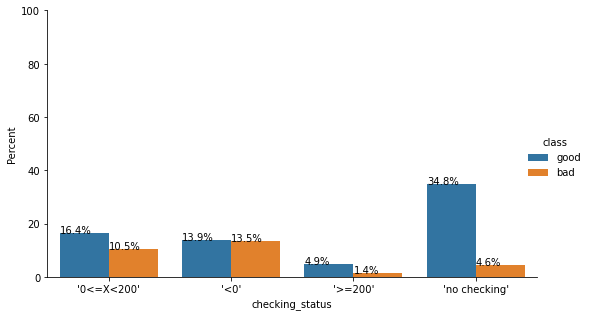

In [7]:
g = sns.catplot(x='checking_status', y='Percent', hue='class', kind='bar', data=checking_status_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable checking status con respecto a la población de cada valor de la variable.

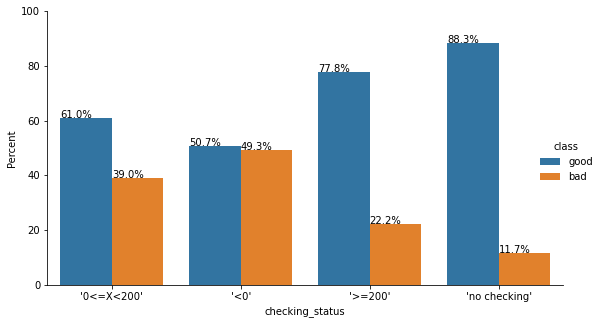

In [8]:
checking_status_riesgo = riesgo.groupby('checking_status')['class'].value_counts(normalize=True)
checking_status_riesgo = checking_status_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='checking_status', y='Percent', hue='class', kind='bar', data=checking_status_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Se convierten los valores de la variable a numérico.

In [9]:
riesgo['checking_status'].replace(["'no checking'", "'>=200'", "'0<=X<200'", "'<0'"],
                        [0,1,2,3], inplace=True)

## duration: 

Esta variable nos indica la duración en meses del préstamo.

Como se trata de una variable numérica, intersa saber como es su distribución

In [10]:
riesgo['duration'].describe()

count    1000.000000
mean       20.903000
std        12.058814
min         4.000000
25%        12.000000
50%        18.000000
75%        24.000000
max        72.000000
Name: duration, dtype: float64

Text(0.5, 1.0, 'duration 1.0941841715555418')

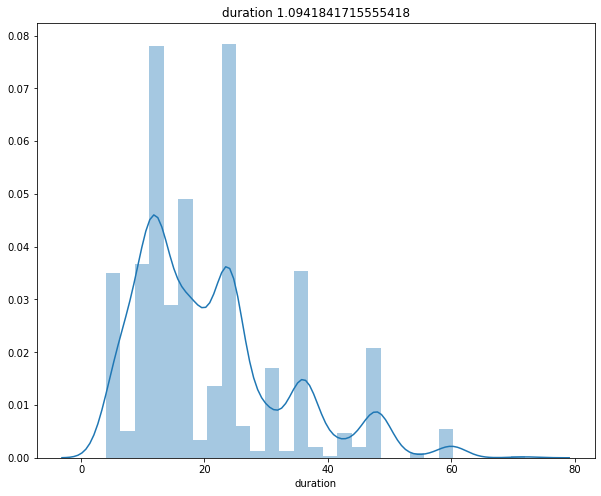

In [11]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['duration'])
plt.title('duration'+' '+str(riesgo['duration'].skew()))

## credit_history: 

Esta variable nos dice si el cliente tiene o tuvo créditos y cual es el estado de los créditos, es decir, como de bueno es su historial crediticio.

In [12]:
riesgo['credit_history'].unique()

array(["'critical/other existing credit'", "'existing paid'",
       "'delayed previously'", "'no credits/all paid'", "'all paid'"],
      dtype=object)

Como podemos ver la variable puede tomar 5 valores:

 * 'critical/other existing credit': La cuenta que tiene en este banco esta en estado crítico o tiene otro crédito existente en su registro.

* 'existing paid': Todos los créditos existentes del cliente han sido pagados correctamente hasta el momento.

* 'delayed previously': El cliente tuvo retraso en algún pago anterior.

* 'no credits/all paid': No tiene historial de crédito y todos los créditos anteriores fueron pagados correctamente.

* 'all paid': Todos los créditos fueron pagados correctamente.

Distribución de la variable credit history con respecto a la población total

In [13]:
credit_history_riesgo = riesgo.groupby('credit_history')['class'].value_counts()
credit_history_riesgo = credit_history_riesgo.rename('Total').reset_index()
credit_history_riesgo['Percent'] = (credit_history_riesgo['Total'] / len(riesgo)) * 100

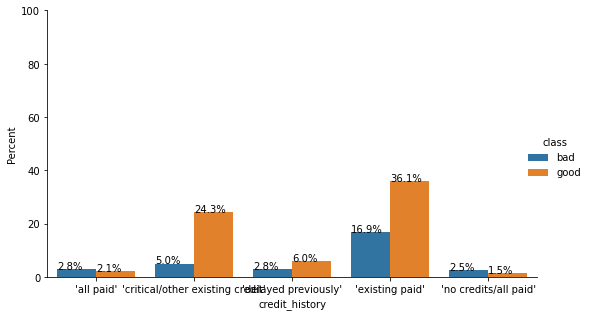

In [14]:
g = sns.catplot(x='credit_history', y='Percent', hue='class', kind='bar', data=credit_history_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable credit history con respecto a la población de cada valor de la variable.

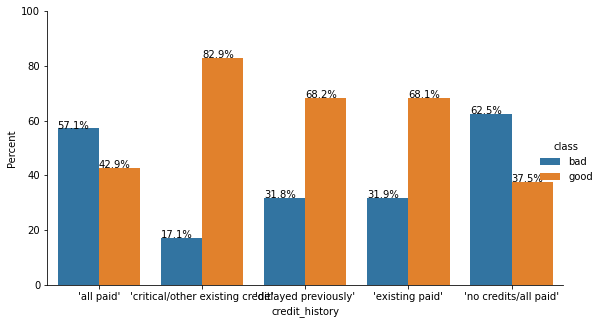

In [15]:
credit_history_riesgo = riesgo.groupby('credit_history')['class'].value_counts(normalize=True)
credit_history_riesgo = credit_history_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='credit_history', y='Percent', hue='class', kind='bar', data=credit_history_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Cambiamos los valores por numéricos

In [16]:
riesgo['credit_history'].replace(["'no credits/all paid'", "'all paid'", "'existing paid'", "'delayed previously'", "'critical/other existing credit'"],
                        [0,1,2,3,4], inplace=True)

## purpose:

 Esta variable nos dice el motivo por el que el cliente solicito el préstamo.

In [17]:
riesgo['purpose'].unique()

array(['radio/tv', 'education', 'furniture/equipment', "'new car'",
       "'used car'", 'business', "'domestic appliance'", 'repairs',
       'other', 'retraining'], dtype=object)

La variable puede tomar los siguientes valores:

* 'radio/tv':Radio o televisión.

* 'education':educación.

* 'furniture/equipement': muebles o equipamneto.

* 'new car': coche nuevo.
* 'used car': coche 2ª mano.

* 'bussiness': trabajo.

* 'domestic appliance': electronica de la casa.

* 'repairs': reparaciones.

* 'other': otro.

* 'retraining': adquirir nuevas habilidades.



In [18]:
purpose_riesgo = riesgo.groupby('purpose')['class'].value_counts()
purpose_riesgo = purpose_riesgo.rename('Total').reset_index()
purpose_riesgo['Percent'] = (purpose_riesgo['Total'] / len(riesgo)) * 100

Distribución de la variable purpose con respectoa la población total

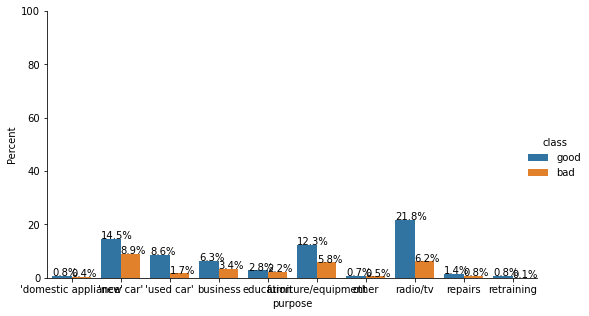

In [19]:
g = sns.catplot(x='purpose', y='Percent', hue='class', kind='bar', data=purpose_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable purpose con respecto a la población de cada valor de la variable

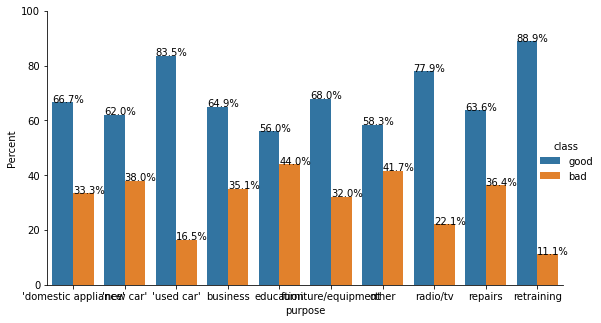

In [20]:
purpose_riesgo = riesgo.groupby('purpose')['class'].value_counts(normalize=True)
purpose_riesgo = purpose_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='purpose', y='Percent', hue='class', kind='bar', data=purpose_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Reemplazamos cada valor por un valor numérico

In [21]:
riesgo['purpose'].replace(['retraining', "'used car'", 'radio/tv', 'furniture/equipment', "'domestic appliance'", 'business', 'repairs', "'new car'", 'other', 'education'],
                        [1,2,3,4,5,6,7,8,9,10], inplace=True)

## credit_amount: 

Esta variable nos indica la cantidad de dinero en la cuenta.

Como la variable es numérica, interesa saber cual es su distribución

In [22]:
riesgo['credit_amount'].describe()

count     1000.000000
mean      3271.258000
std       2822.736876
min        250.000000
25%       1365.500000
50%       2319.500000
75%       3972.250000
max      18424.000000
Name: credit_amount, dtype: float64

Text(0.5, 1.0, 'credit_amount 1.9496276798326209')

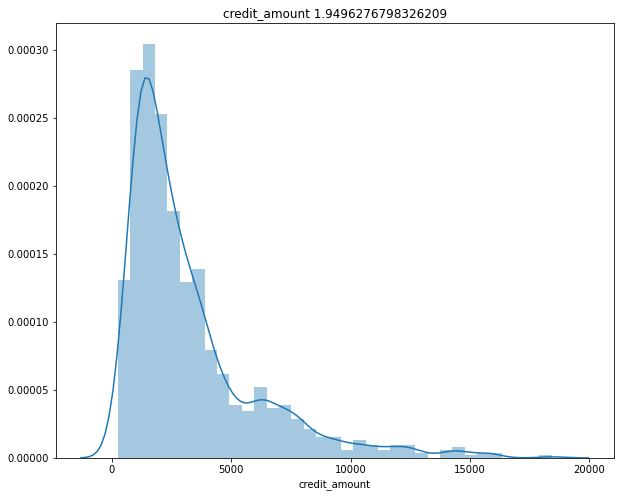

In [23]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['credit_amount'])
plt.title('credit_amount'+' '+str(riesgo['credit_amount'].skew()))

## saving_status:



 Esta variable nos indica los ahorros del cliente y el monto en caso de tenerlos.


In [24]:
riesgo['savings_status'].unique()

array(["'no known savings'", "'<100'", "'500<=X<1000'", "'>=1000'",
       "'100<=X<500'"], dtype=object)

La variable puede tomar 5 valores:

* ' no known savings': El cliente no tiene una cuenta que sepamos.

* '<100': El cliente tiene un ahorros de menos de 100 Dm.

* '100<=x<500': El cliente tiene entre 100 y 500 Dm.

* '500<=x<1000': El cliente tiene entre 500 y 1000 Dm.

* '>=1000': El cliente tiene más de 1000 Dm.



Distribución de la variable saving_status con respecto a la población total

In [25]:
savings_status_riesgo = riesgo.groupby('savings_status')['class'].value_counts()
savings_status_riesgo = savings_status_riesgo.rename('Total').reset_index()
savings_status_riesgo['Percent'] = (savings_status_riesgo['Total'] / len(riesgo)) * 100

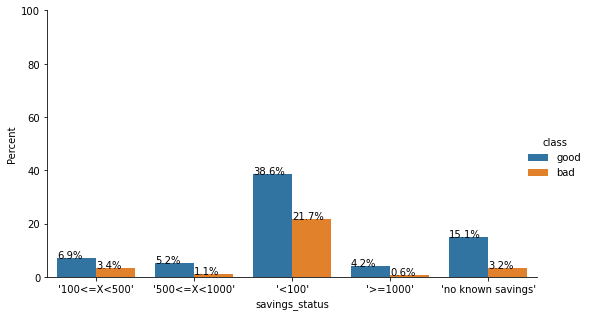

In [26]:
g = sns.catplot(x='savings_status', y='Percent', hue='class', kind='bar', data=savings_status_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

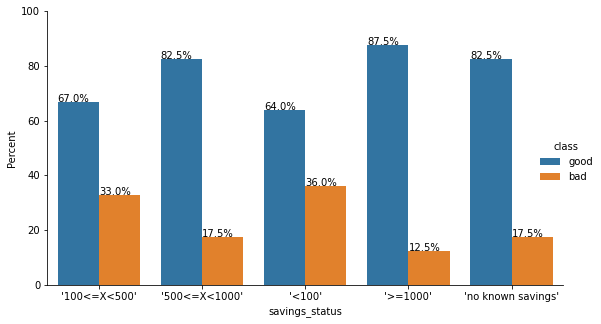

In [27]:
savings_status_riesgo = riesgo.groupby('savings_status')['class'].value_counts(normalize=True)
savings_status_riesgo = savings_status_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='savings_status', y='Percent', hue='class', kind='bar', data=savings_status_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [28]:
riesgo['savings_status'].replace(["'>=1000'", "'500<=X<1000'", "'no known savings'", "'100<=X<500'", "'<100'"],
                        [1,2,3,4,5], inplace=True)

## Employment:

 Esta variable nos indica en años el tiempo que lleva trabajando en la empresa actual.

In [29]:
riesgo['employment'].unique()

array(["'>=7'", "'1<=X<4'", "'4<=X<7'", 'unemployed', "'<1'"],
      dtype=object)

La variable puede tomar 5 valores:

* '>=7': El cliente lleva trabajando como mínimo 7 años en la empresa actual.

* '1<=x<4':El cliente lleva en la empresa entre 1 y 4 años.

* '4<x<=7': El cliente lleva en la empresa entre 4 y 7 años.

* 'unemployed': El cliente no tiene trabajo en este momento.

* '<1': El cliente llevamenos de 1 año en la empresa.



Distribución de la variable employment con respecto a la población total

In [30]:
employment_riesgo = riesgo.groupby('employment')['class'].value_counts()
employment_riesgo = employment_riesgo.rename('Total').reset_index()
employment_riesgo['Percent'] = (employment_riesgo['Total'] / len(riesgo)) * 100

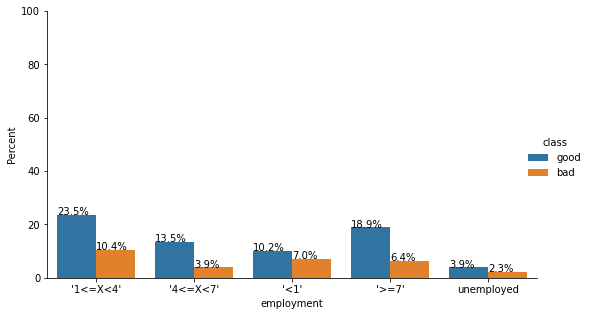

In [31]:
g = sns.catplot(x='employment', y='Percent', hue='class', kind='bar', data=employment_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable employment con respecto a la población de cada valor de la variable.

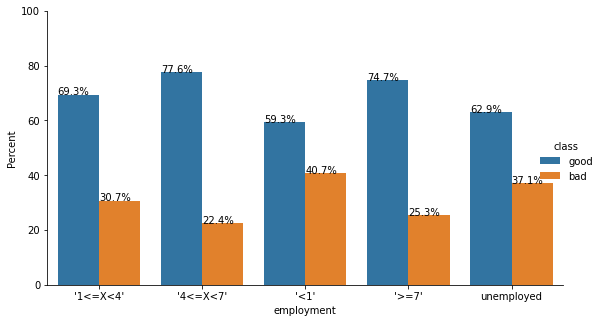

In [32]:
employment_riesgo = riesgo.groupby('employment')['class'].value_counts(normalize=True)
employment_riesgo = employment_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='employment', y='Percent', hue='class', kind='bar', data=employment_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Se cambian los valores de la variable por valores numéricos

In [33]:
riesgo['employment'].replace(["'4<=X<7'", "'>=7'", "'1<=X<4'", 'unemployed', "'<1'"],
                        [1,2,3,4,5], inplace=True)

## installment_commitment: 

Esta variable nos indica el número de plazos de un préstamo.

Como la variable es numérica, nos interesa saber cual es su distribución.

In [34]:
riesgo['installment_commitment'].describe()

count    1000.000000
mean        2.973000
std         1.118715
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: installment_commitment, dtype: float64

Text(0.5, 1.0, 'installment_commitment -0.5313481143125486')

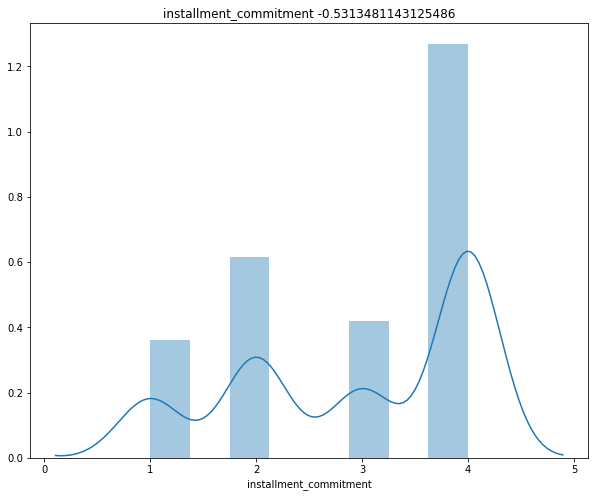

In [35]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['installment_commitment'])
plt.title('installment_commitment'+' '+str(riesgo['installment_commitment'].skew()))

## personal_status: 

Esta variable nos indica el sexo del cliente y su estado civil.

In [36]:
riesgo['personal_status'].unique()

array(["'male single'", "'female div/dep/mar'", "'male div/sep'",
       "'male mar/wid'"], dtype=object)

Como podemos ver la variable puede tomar 4 valores:

* 'male single': Este valor indica que el solicitante esta soltero.

* 'female div/sep/mar':El cliente es una mujer divordiada, casada o que depende de alguien.

* 'male div/sep': El cliente es un hombre divrciado o separado.

* 'male mar/wid': El cliente es un hombre casado o viudo.


Distribución de la variable personal_status con respecto a la población total.

In [37]:
personal_status_riesgo = riesgo.groupby('personal_status')['class'].value_counts()
personal_status_riesgo = personal_status_riesgo.rename('Total').reset_index()
personal_status_riesgo['Percent'] = (personal_status_riesgo['Total'] / len(riesgo)) * 100

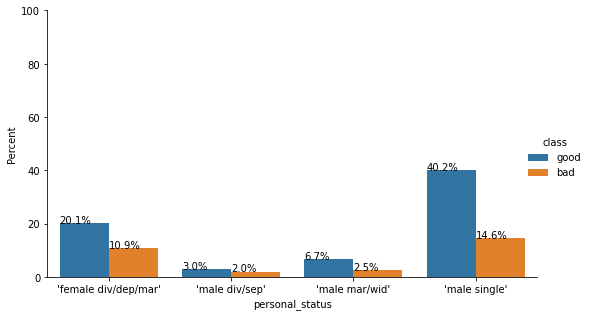

In [38]:
g = sns.catplot(x='personal_status', y='Percent', hue='class', kind='bar', data=personal_status_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

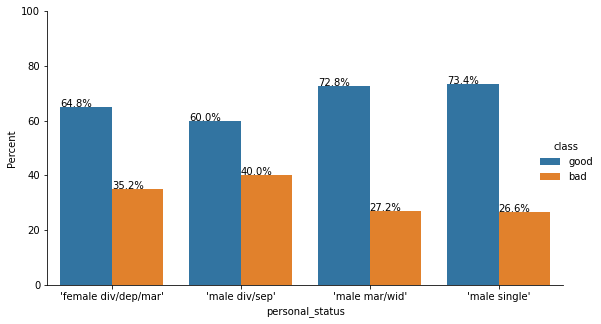

In [39]:
personal_status_riesgo = riesgo.groupby('personal_status')['class'].value_counts(normalize=True)
personal_status_riesgo = personal_status_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='personal_status', y='Percent', hue='class', kind='bar', data=personal_status_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Pasamos a numérico los valores de la variable.

In [40]:
riesgo['personal_status'].replace(["'male single'", "'male mar/wid'", "'female div/dep/mar'", "'male div/sep'"],
                        [1,2,3,4], inplace=True)

## other_parties: 



Esta variable nos indica si el cliente tiene otras partes involucradas en una transacción financiera.

In [41]:
riesgo['other_parties'].unique()

array(['none', 'guarantor', "'co applicant'"], dtype=object)

La variable puede tomar 3 valores:

* 'none': El cliente no tiene partes involucradas en la transacción financiera además del solicitante principal.

* 'guarantor': El cliente cuenta con un avalista involucrado, que acepta asumir la responsabilidad de pagar la deuda en caso de que el solicitante principal no puediera.

* 'co applicant': El cliente cuenta con co-solicitante, esta persona comparte la responsabilidad de la transacción con el solicitante principal.

Distribución de la variable con repecto a la población total.

In [42]:
other_parties_riesgo = riesgo.groupby('other_parties')['class'].value_counts()
other_parties_riesgo = other_parties_riesgo.rename('Total').reset_index()
other_parties_riesgo['Percent'] = (other_parties_riesgo['Total'] / len(riesgo)) * 100

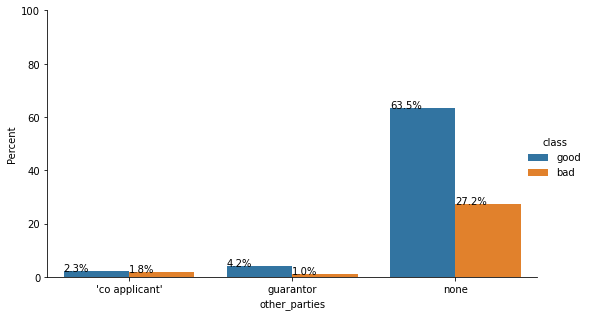

In [43]:
g = sns.catplot(x='other_parties', y='Percent', hue='class', kind='bar', data=other_parties_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

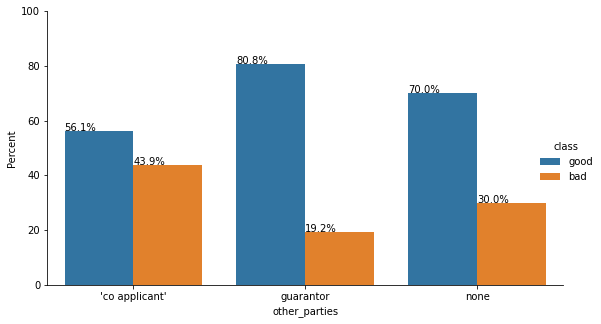

In [44]:
other_parties_riesgo = riesgo.groupby('other_parties')['class'].value_counts(normalize=True)
other_parties_riesgo = other_parties_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='other_parties', y='Percent', hue='class', kind='bar', data=other_parties_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Pasamos los valores de la variable a numérico.

In [45]:
riesgo['other_parties'].replace(['guarantor', 'none', "'co applicant'"],
                        [1,2,3], inplace=True)

## residence_since: 

Esta variable nos indica e número de años que el cliente lleva viviendo en su residencia actual.

Como la variable es numérica, interesa saber como es su distribución.

In [46]:
riesgo['residence_since'].describe()

count    1000.000000
mean        2.845000
std         1.103718
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         4.000000
Name: residence_since, dtype: float64

Text(0.5, 1.0, 'residence_since -0.2725698140337228')

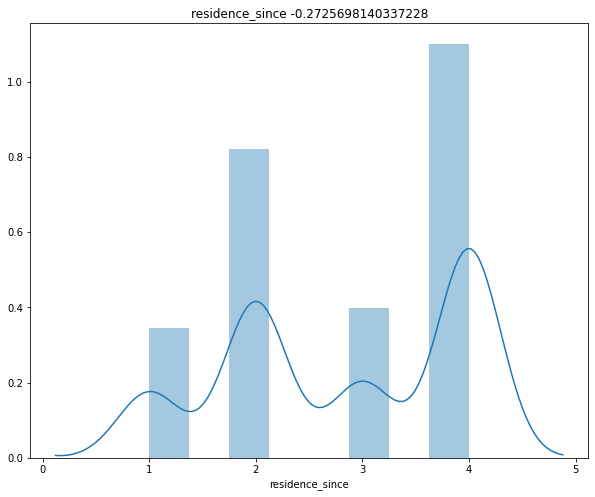

In [47]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['residence_since'])
plt.title('residence_since'+' '+str(riesgo['residence_since'].skew()))

##  property_magnitude: 

Esta variable indica el tipo de propiedad que tiene el cliente.

In [48]:
riesgo['property_magnitude'].unique()

array(["'real estate'", "'life insurance'", "'no known property'", 'car'],
      dtype=object)

Contamos con 4 valores que puede tomar la variable:

* 'real_estate': El cliente posee propiedades inmobiliarias como casas apartamentos o terrenos.

* 'life insurance': El cliente cuenta con un seguro de vida.

* 'no know property': Se desconoce si el cliente posee algún tipo de vivienda o similar a su nombre.

* 'car': El cliente cuenta con un coche.

Distribución de la variable con respecto a la población total

In [49]:
property_magnitude_riesgo = riesgo.groupby('property_magnitude')['class'].value_counts()
property_magnitude_riesgo = property_magnitude_riesgo.rename('Total').reset_index()
property_magnitude_riesgo['Percent'] = (property_magnitude_riesgo['Total'] / len(riesgo)) * 100

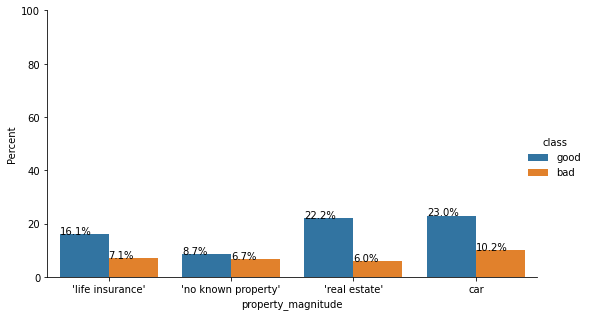

In [50]:
g = sns.catplot(x='property_magnitude', y='Percent', hue='class', kind='bar', data=property_magnitude_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

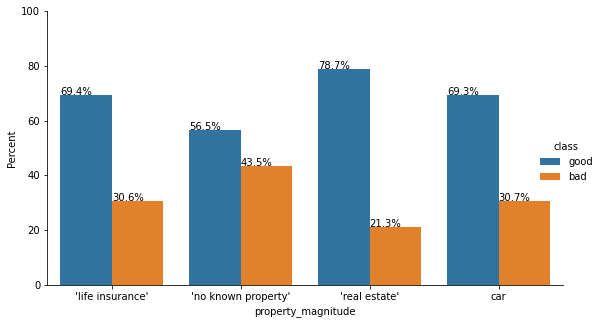

In [51]:
property_magnitude_riesgo = riesgo.groupby('property_magnitude')['class'].value_counts(normalize=True)
property_magnitude_riesgo = property_magnitude_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='property_magnitude', y='Percent', hue='class', kind='bar', data=property_magnitude_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Pasamos los valores a numéricos

In [52]:
riesgo['property_magnitude'].replace(["'real estate'", "'life insurance'", 'car', "'no known property'"],
                        [1,2,3,4], inplace=True)

## age: 

Esta variable nos indeca cual es la edad del cliente.


Debido a que la variable es numérica, nos interesa ver su distribución.

In [53]:
riesgo['age'].describe()

count    1000.000000
mean       35.546000
std        11.375469
min        19.000000
25%        27.000000
50%        33.000000
75%        42.000000
max        75.000000
Name: age, dtype: float64

Text(0.5, 1.0, 'age 1.0207392686768317')

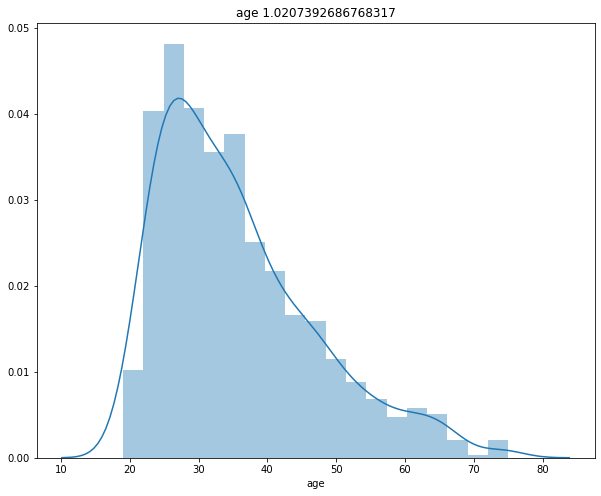

In [54]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['age'])
plt.title('age'+' '+str(riesgo['age'].skew()))

## other payment plans: 

Esta variable representa los diferentes tipos de planes de pagos adicionales disponibles para el cliente.

In [55]:
riesgo['other_payment_plans'].unique()

array(['none', 'bank', 'stores'], dtype=object)

La variable puede tomar 3 valores:

* 'none': El cliente no dispone de ningún pan adicional aparte del pago estandar del prestamo.

* 'store': El cliente ha optadopor un plan de pago adicional ofrecido por una tienda o comercio específico.

* 'bank': El cliente ha optado por un plan de pagos adicionales ofrecido por el banco u otra institución finanaciera que otorgó el préstamo inicial.


Distribución de la variable conr respecto a la población total

In [56]:
other_payment_plans_riesgo = riesgo.groupby('other_payment_plans')['class'].value_counts()
other_payment_plans_riesgo = other_payment_plans_riesgo.rename('Total').reset_index()
other_payment_plans_riesgo['Percent'] = (other_payment_plans_riesgo['Total'] / len(riesgo)) * 100

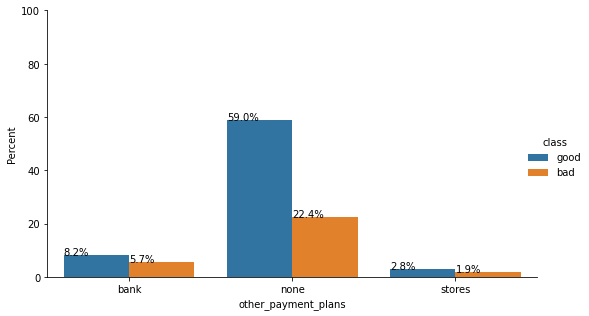

In [57]:
g = sns.catplot(x='other_payment_plans', y='Percent', hue='class', kind='bar', data=other_payment_plans_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población del valor de la variable 

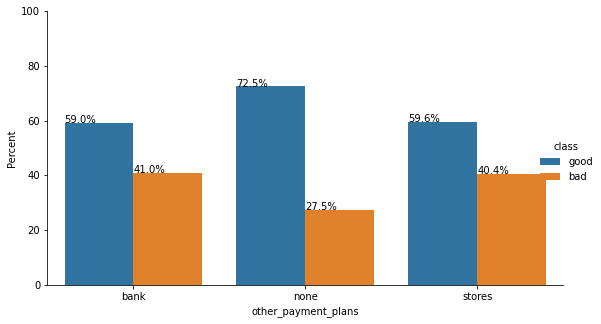

In [58]:
other_payment_plans_riesgo = riesgo.groupby('other_payment_plans')['class'].value_counts(normalize=True)
other_payment_plans_riesgo = other_payment_plans_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='other_payment_plans', y='Percent', hue='class', kind='bar', data=other_payment_plans_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [59]:
riesgo['other_payment_plans'].replace(['none', 'stores', 'bank'],
                        [0,1,2], inplace=True)

## housing:

 Esta variable representa le tipo de situción de vivienda del cliente.

In [60]:
riesgo['housing'].unique()

array(['own', "'for free'", 'rent'], dtype=object)

La variable puede tomar 3 valores:

* 'rent': El cliente reside en una vivienda alquilada.

* 'own': El cliente reside en una vivienda de su propiedad.

* 'for free': El cliente reside en una vivienda que no esta sujeta a pagos de alquiler o de hipoteca. Esto significa que vive en una vivienda proporcionada por el gobierno, o que es de algún familiar o amigo.

Distribución de la variable con respecto a la población total.

In [61]:
housing_riesgo = riesgo.groupby('housing')['class'].value_counts()
housing_riesgo = housing_riesgo.rename('Total').reset_index()
housing_riesgo['Percent'] = (housing_riesgo['Total'] / len(riesgo)) * 100

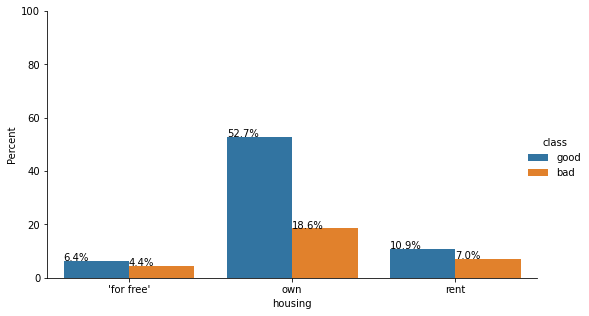

In [62]:
g = sns.catplot(x='housing', y='Percent', hue='class', kind='bar', data=housing_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

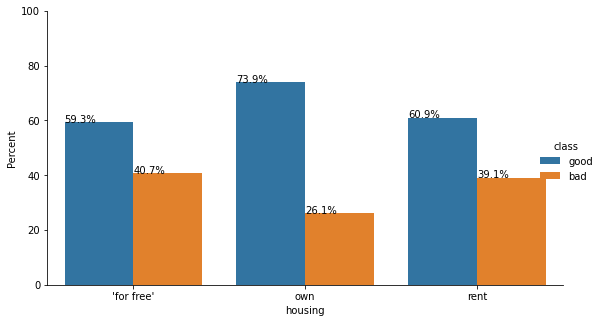

In [63]:
housing_riesgo = riesgo.groupby('housing')['class'].value_counts(normalize=True)
housing_riesgo = housing_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='housing', y='Percent', hue='class', kind='bar', data=housing_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

In [64]:
riesgo['housing'].replace(['own', 'rent', "'for free'"],
                        [1,2,3], inplace=True)

## existing_credits: 


Esta variable nos indicaa el número de cuantas que el cliente tiene abiertas.

Como la variable es numérica, nos interesa ver su distribución.

In [65]:
riesgo['existing_credits'].describe()

count    1000.000000
mean        1.407000
std         0.577654
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         4.000000
Name: existing_credits, dtype: float64

Text(0.5, 1.0, 'existing_credits 1.2725759670020926')

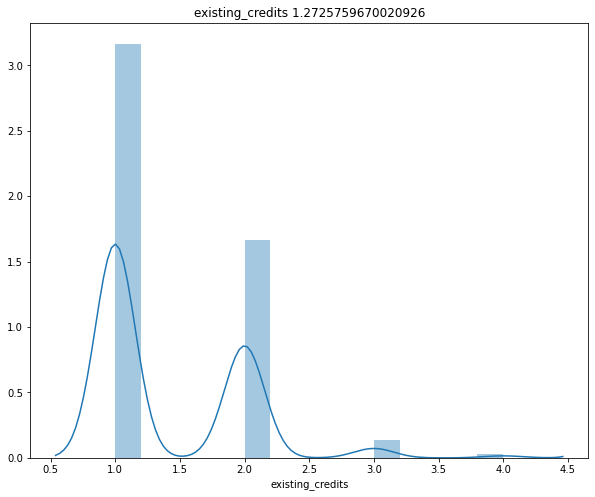

In [66]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['existing_credits'])
plt.title('existing_credits'+' '+str(riesgo['existing_credits'].skew()))

## job: 

Esta variable representa el tipo de ocupación o situación laboral del cliente.

In [67]:
riesgo['job'].unique()

array(['skilled', "'unskilled resident'", "'high qualif/self emp/mgmt'",
       "'unemp/unskilled non res'"], dtype=object)

La variable puede tomar 4 valores:

* 'skilled': El cliente tiene un trabajo que requiere habilidades especializadas, nivel avanzado de conocimiento.

* 'unskilled resident': El cliente tiene un trabjo que no requiere habilidades específicas, puede ser nivel de entrada o bajo.

* 'high qualified/self emp/mgmt':El cliente tiene uun trabajo que iimplica alto nivel de calificacion, es autónomo o trabaja en un puesto de gestión.

* 'unemp/ unskilled non res':  El cliente está desempleado y además no tiene habilidades especializadas.

Distribución de la variable con respecto a la población total

In [68]:
job_riesgo = riesgo.groupby('job')['class'].value_counts()
job_riesgo = job_riesgo.rename('Total').reset_index()
job_riesgo['Percent'] = (job_riesgo['Total'] / len(riesgo)) * 100

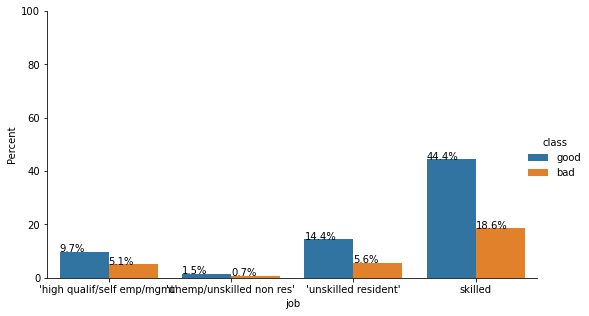

In [69]:
g = sns.catplot(x='job', y='Percent', hue='class', kind='bar', data=job_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

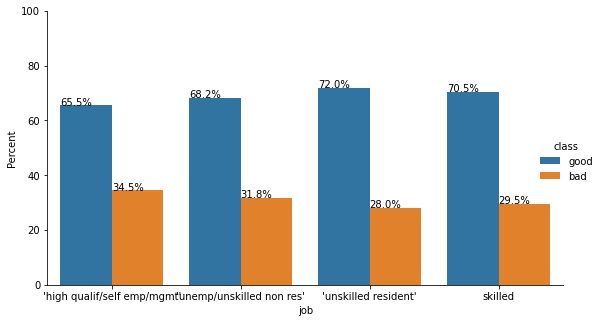

In [70]:
job_riesgo = riesgo.groupby('job')['class'].value_counts(normalize=True)
job_riesgo = job_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='job', y='Percent', hue='class', kind='bar', data=job_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Cambiamos los valores de la variable a numérico.

In [71]:
riesgo['job'].replace(["'unskilled resident'", 'skilled', "'unemp/unskilled non res'", "'high qualif/self emp/mgmt'"],
                        [1,2,3,4], inplace=True)

## num_depentents: 

Esta variable nos indica el número de personas que dependen economicamente del cliente.

Como la variable es numérica nos interesa ver su distribución.

In [72]:
riesgo['num_dependents'].describe()

count    1000.000000
mean        1.155000
std         0.362086
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: num_dependents, dtype: float64

c:\Users\alegr\anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'num_dependents 1.909444721297485')

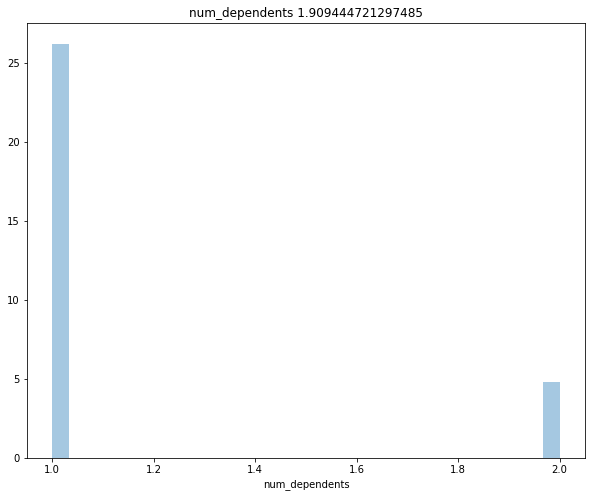

In [73]:
plt.figure(figsize=(10,8))
sns.distplot(riesgo['num_dependents'])
plt.title('num_dependents'+' '+str(riesgo['num_dependents'].skew()))

## own_telephone:

 Esta variable nos indica si el cliente posee o no un teléfono móvil propio.

In [74]:
riesgo['own_telephone'].unique()

array(['yes', 'none'], dtype=object)

Distribución de la variable con respecto a la población total

In [75]:
own_telephone_riesgo = riesgo.groupby('own_telephone')['class'].value_counts()
own_telephone_riesgo = own_telephone_riesgo.rename('Total').reset_index()
own_telephone_riesgo['Percent'] = (own_telephone_riesgo['Total'] / len(riesgo)) * 100

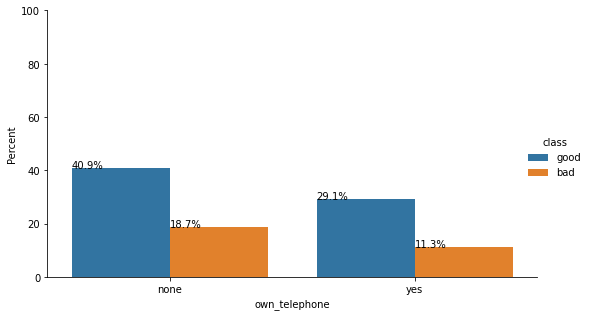

In [76]:
g = sns.catplot(x='own_telephone', y='Percent', hue='class', kind='bar', data=own_telephone_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

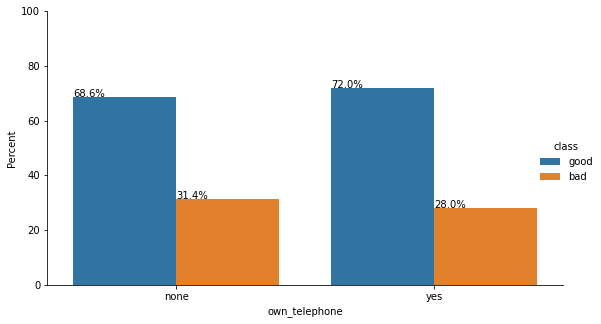

In [77]:
own_telephone_riesgo = riesgo.groupby('own_telephone')['class'].value_counts(normalize=True)
own_telephone_riesgo = own_telephone_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='own_telephone', y='Percent', hue='class', kind='bar', data=own_telephone_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Cambiamos los valores a numéricos

In [78]:
riesgo['own_telephone'].replace(['yes', 'none'],
                        [1,0], inplace=True)

## foreign_work: 

Esta variable nos indica si el cliente es un trabajador extranjero o no.

In [79]:
riesgo['foreign_worker'].unique()

array(['yes', 'no'], dtype=object)

Distribución de la variable con repecto a la población total.

In [80]:
foreign_worker_riesgo = riesgo.groupby('foreign_worker')['class'].value_counts()
foreign_worker_riesgo = foreign_worker_riesgo.rename('Total').reset_index()
foreign_worker_riesgo['Percent'] = (foreign_worker_riesgo['Total'] / len(riesgo)) * 100

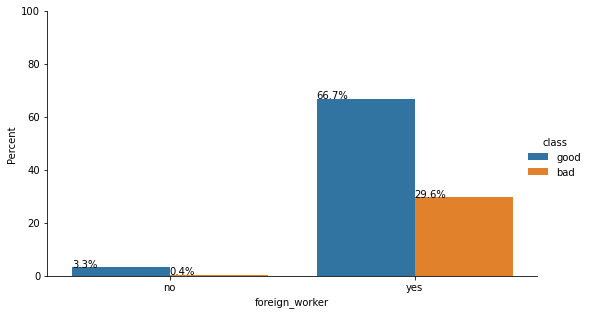

In [81]:
g = sns.catplot(x='foreign_worker', y='Percent', hue='class', kind='bar', data=foreign_worker_riesgo, height=10)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Distribución de la variable con respecto a la población de cada valor de la variable.

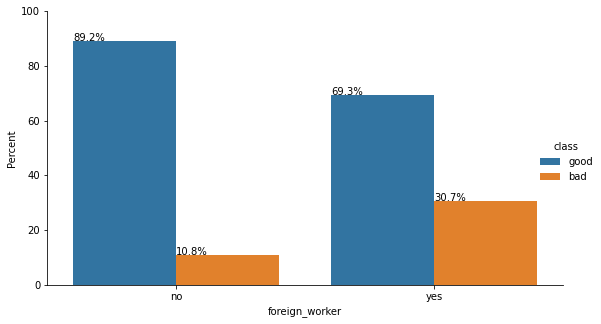

In [82]:
foreign_worker_riesgo = riesgo.groupby('foreign_worker')['class'].value_counts(normalize=True)
foreign_worker_riesgo = foreign_worker_riesgo.mul(100).rename('Percent').reset_index()
g = sns.catplot(x='foreign_worker', y='Percent', hue='class', kind='bar', data=foreign_worker_riesgo, height=15)
g.ax.set_ylim(0,100)
g.fig.set_size_inches(8, 4)
for p in g.ax.patches:
    txt = str(round(p.get_height(),1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

Cambiamos los valores de la variable a numérico

In [83]:
riesgo['foreign_worker'].replace(['no', 'yes'],
                        [0,1], inplace=True)

## class:

A continuación veremos un análisis de la variable class, la cual es nuestra variable objetivo. Esta variable es la que indica si el cliente es un bueno o malo. Es necesario realizar un análisis de esta variable para que no exista un sesgo en los datos, como tener todos buenos clientes o malos.

In [86]:
riesgo['class'].value_counts()

0    700
1    300
Name: class, dtype: int64

Como podemos ver tenemos 1000 clientes, el 30% son malos y el 70% restantes buenos.

 Esto es muy común en datos bancarios, por lo que los datos se tratam como están y no habría que ajustar los datos mediante undersampling u oversampling.

El objetivo del proyecto es determinar la probabilidad que tiene un cliente de pagar o no, por lo que se tomará como 1 al cliente malo, es decir, 1 serán los clientes que no han pagado y 0 los que sí.

In [87]:
riesgo['class'].replace(['good', 'bad'],
                        [0,1], inplace=True)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

## Matriz de correlación

El siguiente paso será entender como de relacionadas están las variables con la variable objetivo. Para ello haremos una matriz de correlación.

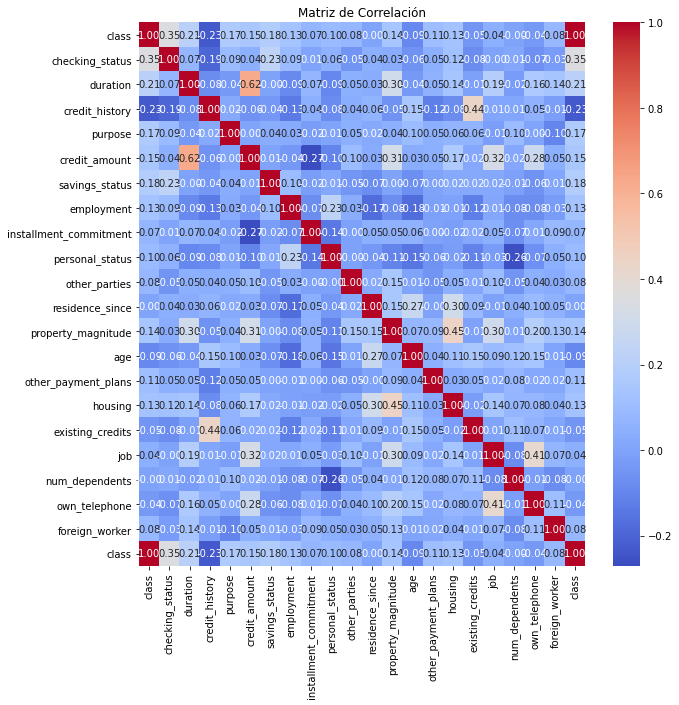

In [88]:
subset_1 = pd.concat([riesgo['class'],riesgo.iloc[:, :]],axis=1)

correlation_matrix_1 = subset_1.corr()

plt.figure(figsize=(10, 10))

sns.heatmap(correlation_matrix_1, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Matriz de Correlación')

plt.show()

Podemos ver, que hay variables de las que podemos prescindir porque su correlación con la variable objetivo class es menor que el 1% (residence_since, num_dependents).

Por lo que se procede a eliminarlas, junto con la variable objetivo de la lista de variables.

In [89]:
variables=list(riesgo.columns)
variables.remove('residence_since')
variables.remove('num_dependents')
variables.remove('class')


# Modelos

Definimos una función que nos de el resumen de cada uno de los modelos que se van a realizar.

In [91]:
def show_model_summary(model_name, y_true, y_pred, y_pred_prob):
        print('%s model summary' %model_name)
        print('Classification Report: ')
        print(classification_report(y_true, y_pred))
        print('Confusion Matrix: ')
        print(confusion_matrix(y_true, y_pred))
        print('Logloss: ', log_loss(y_true, y_pred_prob[:, 1]))

        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auc_score = roc_auc_score(y_true, y_pred_prob[:, 1])
        print('auc: ', auc_score)
        model_metrics = {'accuracy': accuracy, 'precision': precision, 'f1_score': f1, 'log_loss': log_loss(y_true, y_pred_prob), 'auc': auc_score}
        return model_metrics

Se definen X e Y, como las variables y la variable objetivo.

In [92]:
X = riesgo.loc[:, variables]
y = riesgo.loc[:, ['class']]

Para continuar, se debe hacer una transformación de las variables. En este caso se utilizará el método Yeo-Yonhson, acerca los datos a una distribución normal, se ha decidido utilizar este método en vez de otro ya que puede aplicarse a datos positivos y negativos, a diferencia de otras transformaciones que solo aceptan datos positivos.

In [93]:
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
X[variables] = pt.fit_transform(X[variables])

El siguiente paso será separar la base de datos en train y test. Se utiliza un random_state para que siempre coja los mismo clientes que la primera vez, ya que sino cambiarían todo el rato los resultados.

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=800, test_size=0.3)

Escalamos los datos, es decir, transformar los valores de las características de modo que estén confinados en un rango. x(escalado)=(x-media)/desv

In [95]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

## Regresión logística

La regresión logística, es un método que funciona mediange el ajuste de una curva logística a los datos. Primero se define un modelo de regresión que relacione las variables independientes con la variable objetivo, utilizando distintas técnicas se estiman los coeficientes del modelo que mejor se ajustan para poder evaluar el modelo y así finalmente se puede utilizar para predecir.

In [356]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression()

Se hacen las prediccciones para el conjunto test. La primera parte devuelve la clase y la segunda devuelve la probabilidad de que pertenezca a cada una de las clases.

In [357]:
y_pred = lr.predict(X_test)
y_pred_prob = lr.predict_proba(X_test)

Se analizan las probabilidades de que se pertenezca a una clase u otra en el conjunto test, se puede comprobar que el promedio de probabilidades se acerca considerablemente a la distribución de clientes buenos y malos.

In [358]:
df_new = pd.DataFrame()
df_new['proability_0_Entrenamiento'], df_new['probability_1_Entrenamiento'] = y_pred_prob.T
df_new.describe()

,proability_0_Entrenamiento,probability_1_Entrenamiento
count,300.000000,300.000000
mean,0.683512,0.316488
std,0.247534,0.247534
min,0.080597,0.007687
25%,0.512671,0.094724
50%,0.744904,0.255096
75%,0.905276,0.487329
max,0.992313,0.919403


El siguiente código nos indican los p-value de cada una de las variables del dataset.

Se reechaza la hipotesis nula si el p-value > 0.05 esto quiere decir que la variable no es significativa para el modelo.

In [359]:
from sklearn.feature_selection import f_regression

freg=f_regression(X_train, y_train)

p=freg[1]

pvalue_table = pd.DataFrame(list(X.columns)).copy()
pvalue_table.insert(len(pvalue_table.columns),"p-value",p.round(3))
pvalue_table

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,0,p-value
0,checking_status,0.000
1,duration,0.000
2,credit_history,0.000
3,purpose,0.000
4,credit_amount,0.074
5,savings_status,0.000
6,employment,0.005
7,installment_commitment,0.013
8,personal_status,0.016
9,other_parties,0.114


In [360]:
show_model_summary('Logreg', y_test, y_pred, y_pred_prob)

Logreg model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.82      0.88      0.85       213
           1       0.65      0.53      0.58        87

    accuracy                           0.78       300
   macro avg       0.73      0.71      0.72       300
weighted avg       0.77      0.78      0.77       300

Confusion Matrix: 
[[188  25]
 [ 41  46]]
Logloss:  0.47072918161931465
auc:  0.8134477362257838


{'accuracy': 0.78,
 'precision': 0.647887323943662,
 'f1_score': 0.5822784810126582,
 'log_loss': 0.47072918161931465,
 'auc': 0.8134477362257838}

Como podemos ver el modelo predice bien debido a que 'auc' (área bajo la curva) es cercano a 1, nos dice como de bien está separando las clases. De igual modo no debemos fiarnos mucho si fuese muy cercano a 1 debido que podría exisitir un sobreentrenamiento.

Por otro lado la matriz de confusión, se puede ver que se predicen correctamnete 188 buenos clientes de 213 y se predicen adecuadamnete 46 malos clientes de 87. Del mismo modo se predicen mal 66 clientes, 41 de ellos tendrían que ser buenos clientes y los predice como malos y 25 tendrían que ser malos clientes y los predice como buenos.

## Random Forest

Los modelos de Random Forest van creando a partir de los datos de entrenamiento árboles a partir de seleccionar al azar datos del conjunto de entrenamiento, por tanto para poder repetir el experimento se pone un random_state(semilla) que inicializa la creación de los datos al azar en el mismo punto cada vez que se ejecuta.

In [96]:
model_rf = RandomForestClassifier(random_state=2122)

ros = RandomUnderSampler(random_state=1023)
X_train, y_train= ros.fit_resample(X_train, y_train)

model_rf.fit(X_train, np.ravel(y_train))
y_pred_rf = model_rf.predict(X_test)
y_pred_prob_rf = model_rf.predict_proba(X_test)


In [97]:
show_model_summary('Randomforest', y_test, y_pred_rf, y_pred_prob_rf)

Randomforest model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.64      0.74       213
           1       0.47      0.79      0.59        87

    accuracy                           0.68       300
   macro avg       0.68      0.72      0.67       300
weighted avg       0.76      0.68      0.70       300

Confusion Matrix: 
[[136  77]
 [ 18  69]]
Logloss:  0.5775410704640249
auc:  0.791268684906373


{'accuracy': 0.6833333333333333,
 'precision': 0.4726027397260274,
 'f1_score': 0.592274678111588,
 'log_loss': 0.5775410704640249,
 'auc': 0.791268684906373}

Se puede observar que Random Forest tiene un auc menor que el modelo de Regresión logística. Clasifica bien a 136 clientes buenos y 69 malos. Del mismo modo, clasifica mal a 95 clientes, 77 debería de haberlos clasificado como buenos y 18 como malos

## XG-Boost

Continúamos con el modelo de XG-Boost, este modelo hace sus predicciones sobre un primer árbol de decisión, se calculan los residuales entre lo que se predijo y las observaciones y se construye otro árbol teniendo estos residuales como objetivo. Este proceso se va repitiendo utilizando los residuales del árbol anterior, por lo que cada árbol irá aprendiendo de su anterior.

In [363]:
modelxg = XGBClassifier()

modelxg.fit(X_train, y_train)

y_pred_xg = modelxg.predict(X_test)
y_pred_prob_xg = modelxg.predict_proba(X_test)

In [364]:
show_model_summary('XG-Boost', y_test, y_pred_xg, y_pred_prob_xg)

XG-Boost model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.62      0.73       213
           1       0.46      0.78      0.58        87

    accuracy                           0.67       300
   macro avg       0.67      0.70      0.65       300
weighted avg       0.75      0.67      0.69       300

Confusion Matrix: 
[[133  80]
 [ 19  68]]
Logloss:  0.9110729723472152
auc:  0.7521450542334466


{'accuracy': 0.67,
 'precision': 0.4594594594594595,
 'f1_score': 0.5787234042553192,
 'log_loss': 0.9110729723472152,
 'auc': 0.7521450542334466}

Este modelo tiene un auc de 0.75, lo que indica que predice bien, podemos ver en la matriz de confusión que se han clasificado bien 201 clientes de los cuales 133 son buenos clientes y 68 son malos, sin embargo, ha clasificado mal 99 clientes.

## PCA

Interesa saber cuales son las variables de nuestro dataset que tienen mayor importancia con respecto a la variable objetivo, para posteriormente hacer estos 3 modelos con Análisis PCA.

In [365]:
importance_scores = modelxg.feature_importances_ # obtener los valores de importancia
feature_names = X.columns 

feature_importance = dict(zip(feature_names, importance_scores))

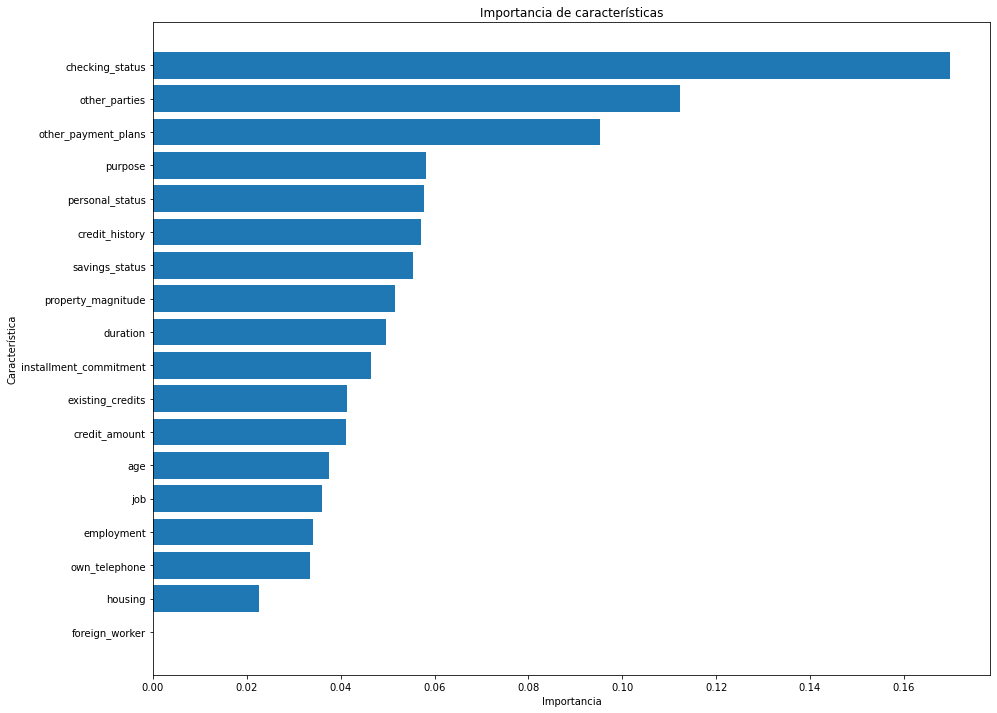

In [366]:
import matplotlib.pyplot as plt

sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=False)}

fig, ax = plt.subplots(figsize=(15,12))

ax.barh(list(sorted_importance.keys()), list(sorted_importance.values()))

ax.set_title("Importancia de características")
ax.set_xlabel("Importancia")
ax.set_ylabel("Característica")

plt.show()

El siguiente paso será hacer un PCA, para poder reducir la dimensionalidad del dataset.

In [367]:
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

In [368]:
columnas = list(riesgo.columns)
columnas.remove('class')

Para comenzar, se debe esclar la bbdd para poder hacer el, ya que sino algunas variables tendrían más peso que otras por tener valores mayores.

In [369]:
scaler= StandardScaler()
riesgo_escalada= riesgo.copy()
riesgo_escalada.drop('class', axis=1, inplace=True)

In [370]:
riesgo_escalada= scaler.fit_transform(riesgo_escalada)


Se decide hacer el análisis de componenetes principales con 12 combinaciones lineales distintas

In [371]:
pca_riesgo = make_pipeline(PCA(n_components = 12))
pca_riesgo.fit(riesgo_escalada)

modelo_pca = pca_riesgo.named_steps['pca']

In [372]:
pd.DataFrame(
    data    = modelo_pca.components_,
    columns = columnas,
    index   = ['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6', 'PC7', 'PC8','PC9','PC10', 'PC11','PC12']
)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker
PC1,0.023097,0.388302,0.003278,0.029032,0.432582,-0.026166,-0.136652,0.006925,-0.154113,0.119656,0.194218,0.422956,0.168987,0.078644,0.310403,0.067129,0.349692,0.045417,0.329831,0.133743
PC2,-0.255413,-0.185567,0.446586,0.060870,-0.189281,-0.167049,-0.332932,0.144688,-0.282927,-0.017515,0.225116,-0.082897,0.361959,-0.022655,-0.056197,0.411998,-0.094186,0.213559,0.048310,-0.050301
PC3,0.411308,-0.106211,-0.245278,0.300834,-0.116880,0.205086,-0.009194,-0.021550,-0.130417,-0.139323,0.271631,0.112770,0.154379,0.216711,0.360569,-0.070695,-0.238339,0.358059,-0.253351,-0.186251
PC4,0.002573,0.192446,0.080407,0.127543,0.375474,0.129842,0.004061,-0.412874,-0.245260,-0.082838,-0.376475,-0.167773,-0.120234,0.140579,-0.281822,0.204410,-0.025403,0.354207,-0.004459,-0.305704
PC5,0.101653,-0.228115,0.313556,0.363102,0.013244,0.198223,0.332718,-0.311275,0.395194,0.263266,0.084862,0.017967,0.090362,-0.200332,0.155647,0.282373,0.158153,-0.140957,0.093869,-0.146443
PC6,-0.348172,-0.114874,-0.192903,0.005591,0.099917,-0.580086,-0.036452,-0.449572,0.109692,0.161452,0.166268,0.012425,0.091554,-0.072373,0.137137,-0.306835,-0.122038,0.118640,-0.030033,-0.236786
PC7,-0.089509,-0.270491,-0.200866,0.317979,-0.206226,-0.113565,0.196171,0.261481,-0.118381,0.080426,-0.266545,0.006311,0.173556,0.337958,-0.151713,-0.182113,0.394672,0.080763,0.355918,-0.184471
PC8,-0.068497,0.114968,0.061803,0.179960,-0.040775,-0.033913,0.045173,0.295671,-0.282553,0.660258,-0.192227,0.218112,-0.247704,-0.227435,0.059018,-0.029520,-0.125046,0.067755,-0.317015,-0.123065
PC9,0.163455,-0.053203,-0.046533,-0.110920,0.019087,0.180493,-0.134630,0.066697,-0.214880,-0.147745,0.048891,-0.115354,0.107261,-0.696205,-0.010560,-0.276256,0.204768,0.014097,0.189314,-0.407635
PC10,0.202862,0.333105,-0.019455,0.495419,0.153575,-0.220270,-0.291965,0.188949,0.180454,-0.029078,0.111625,-0.185936,0.118231,0.051686,-0.262850,-0.043576,-0.140018,-0.419431,-0.052767,-0.206465


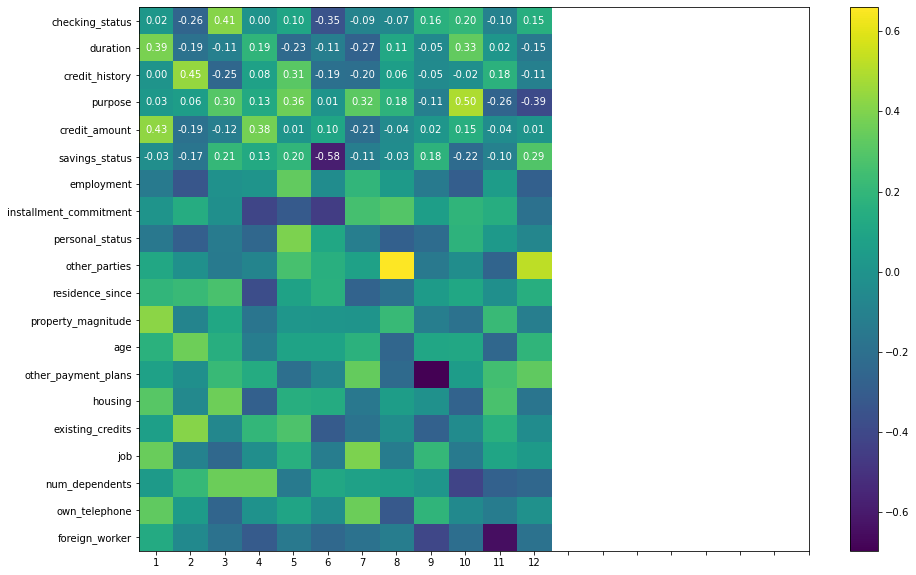

In [373]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10))
componentes = modelo_pca.components_
plt.imshow(componentes.T, cmap='viridis', aspect='auto')
for i in range(6):
    for j in range(modelo_pca.n_components_):
        text = ax.text(j, i, f'{componentes[j, i]:.2f}', ha='center', va='center', color='w')

plt.yticks(range(len(columnas)), columnas)
plt.xticks(range(len(columnas)), np.arange(modelo_pca.n_components_) + 1)
plt.grid(False)
plt.colorbar();

Ahora tenemos que ver cual es el porcentaje de varianza explicada por cada componente. Esto significa cuanta variabilidad de los datos es explicada por cada componenete, se trata de una medida importante ya que evalúa cuánta información útil proporciona cada componenete en la reducción de la dimensionalidad de los datos.

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.12946461 0.09693441 0.07446911 0.06629986 0.06253766 0.05876958
 0.05387226 0.05205818 0.04926551 0.04575274 0.04295402 0.04162741]
----------------------------------------------------
Porcentaje de varianza explicada acumulada
----------------------------------------------------
[0.12946461 0.22639902 0.30086812 0.36716798 0.42970564 0.48847521
 0.54234748 0.59440566 0.64367116 0.6894239  0.73237792 0.77400533]


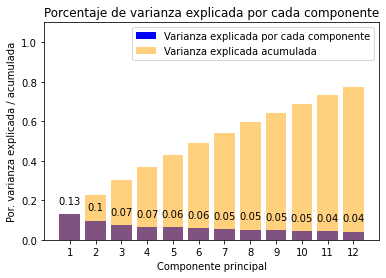

In [374]:
# Supongamos que ya tienes un modelo_pca ajustado
prop_varianza_acum = modelo_pca.explained_variance_ratio_.cumsum()
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(modelo_pca.explained_variance_ratio_)

print('----------------------------------------------------')
print('Porcentaje de varianza explicada acumulada')
print('----------------------------------------------------')
print(prop_varianza_acum)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))

# Barra para el porcentaje de varianza explicada por cada componente
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = modelo_pca.explained_variance_ratio_,
    color='blue',
    label='Varianza explicada por cada componente'
)

# Barra para el porcentaje de varianza explicada acumulada
ax.bar(
    x      = np.arange(modelo_pca.n_components_) + 1,
    height = prop_varianza_acum,
    color='orange',
    label='Varianza explicada acumulada',
    alpha=0.5
)

# Anotaciones en las barras del porcentaje de varianza explicada por cada componente
for x, y in zip(np.arange(modelo_pca.n_components_) + 1, modelo_pca.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
    )

# Configuración del gráfico
ax.set_xticks(np.arange(modelo_pca.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada / acumulada')
ax.legend()

plt.show()

Como se puede ver, interesa coger hasta la componenete principal 10, ya que proporcionana el 70% de la información.

Ahora se van a hacer otra vez los 3 modelos pero con los componentes principales (PCA), con ello veremos si los modelos mejoran, empeoran o se quedan iguales.

In [375]:
pca= PCA(n_components=10)
modelo_pca= pca.fit_transform(riesgo_escalada)
riesgo_pca=pd.DataFrame(modelo_pca,columns=['PC1', 'PC2', 'PC3', 'PC4','PC5','PC6', 'PC7', 'PC8','PC9','PC10'])

In [376]:
X = riesgo_pca
y = riesgo['class']

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=800, test_size=0.3)

### Modelo Regresión logística con PCA

In [378]:
lr_pca = LogisticRegression()
lr_pca.fit(X_train, y_train)

LogisticRegression()

In [379]:
y_pred = lr_pca.predict(X_test)
y_pred_prob = lr_pca.predict_proba(X_test)

In [380]:
df_new = pd.DataFrame()
df_new['proability_0_Entrenamiento'], df_new['probability_1_Entrenamiento'] = y_pred_prob.T
df_new.describe()

,proability_0_Entrenamiento,probability_1_Entrenamiento
count,300.000000,300.000000
mean,0.687718,0.312282
std,0.244472,0.244472
min,0.035686,0.009445
25%,0.505513,0.101532
50%,0.746805,0.253195
75%,0.898468,0.494487
max,0.990555,0.964314


In [381]:
freg=f_regression(X_train, y_train)

p=freg[1]

pvalue_table = pd.DataFrame(list(X.columns)).copy()
pvalue_table.insert(len(pvalue_table.columns),"p-value",p.round(3))
pvalue_table

,0,p-value
0,PC1,0.000
1,PC2,0.000
2,PC3,0.000
3,PC4,0.635
4,PC5,0.304
5,PC6,0.000
6,PC7,0.844
7,PC8,0.013
8,PC9,0.003
9,PC10,0.000


In [382]:
show_model_summary('LogregPCA', y_test, y_pred, y_pred_prob)

LogregPCA model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       213
           1       0.59      0.51      0.55        87

    accuracy                           0.76       300
   macro avg       0.70      0.68      0.69       300
weighted avg       0.75      0.76      0.75       300

Confusion Matrix: 
[[183  30]
 [ 43  44]]
Logloss:  0.4907438174633085
auc:  0.7924019211051752


{'accuracy': 0.7566666666666667,
 'precision': 0.5945945945945946,
 'f1_score': 0.5465838509316772,
 'log_loss': 0.4907438174633085,
 'auc': 0.7924019211051752}

Como se puede ver en en summary, el auc es un 0.79, y el modelo clasifica bien 183 clientes buenos y 44, sin embargo ha clasificado mal 73 clientes.

Vamos a quitar las componentes principales que tengan un p-value mayor de 0.05, es decir quitaremos PC4, PC5 y PC7

In [383]:
X = riesgo_pca.iloc[:,[0,1,2,5,7,8,9]]

In [384]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=800, test_size=0.3)
lr_pca = LogisticRegression()
lr_pca.fit(X_train, y_train)

LogisticRegression()

In [385]:
y_pred = lr_pca.predict(X_test)
y_pred_prob = lr_pca.predict_proba(X_test)

In [386]:
show_model_summary('Logreg', y_test, y_pred, y_pred_prob)

Logreg model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       213
           1       0.60      0.49      0.54        87

    accuracy                           0.76       300
   macro avg       0.70      0.68      0.69       300
weighted avg       0.75      0.76      0.75       300

Confusion Matrix: 
[[184  29]
 [ 44  43]]
Logloss:  0.49229423470169686
auc:  0.79110679402083


{'accuracy': 0.7566666666666667,
 'precision': 0.5972222222222222,
 'f1_score': 0.5408805031446541,
 'log_loss': 0.49229423470169686,
 'auc': 0.79110679402083}

Como se puede ver, el quitar las 3 PCA no ha afectado al rendimiento del modelo como se esperaba. Sin embargo, a la hora de llevar un modelo a producción es mas sencillo trabajar con menos variables, por o que podemos escoger el mejor modelo de regresión logística este último, ya que ocupa menos recursos. Debido a que no ha supuesto casi ninguna diferencia, para los modelos posteriores no se tendrán en cuneta los p-valores, por lo que se hará el modelo con todas las componentes.

### Modelo Random Forest con PCA

In [387]:
X = riesgo_pca
y = riesgo['class']

In [388]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=800, test_size=0.3)

In [389]:
model_rf = RandomForestClassifier(random_state=2122)

ros = RandomUnderSampler(random_state=1023)
X_train, y_train= ros.fit_resample(X_train, y_train)

model_rf.fit(X_train, np.ravel(y_train))
y_pred_rf = model_rf.predict(X_test)
y_pred_prob_rf = model_rf.predict_proba(X_test)

In [390]:
show_model_summary('RandomforestPCA', y_test, y_pred_rf, y_pred_prob_rf)

RandomforestPCA model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.68      0.75       213
           1       0.47      0.71      0.57        87

    accuracy                           0.69       300
   macro avg       0.66      0.69      0.66       300
weighted avg       0.74      0.69      0.70       300

Confusion Matrix: 
[[144  69]
 [ 25  62]]
Logloss:  0.5901535342496974
auc:  0.7580540715557714


{'accuracy': 0.6866666666666666,
 'precision': 0.4732824427480916,
 'f1_score': 0.5688073394495413,
 'log_loss': 0.5901535342496974,
 'auc': 0.7580540715557714}

Pese que su auc es menor, es capaz de predecir mejor la clase 0, es decir, los clientes que no se atrasan en los pagos o que terminan de pagar.

### Modelo XGBoost con PCA

In [391]:
modelxg = XGBClassifier()

modelxg.fit(X_train, y_train)

y_pred_xg = modelxg.predict(X_test)
y_pred_prob_xg = modelxg.predict_proba(X_test)

In [392]:
show_model_summary('XG-BoostPCA', y_test, y_pred_xg, y_pred_prob_xg)

XG-BoostPCA model summary
Classification Report: 
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       213
           1       0.42      0.63      0.50        87

    accuracy                           0.64       300
   macro avg       0.61      0.64      0.61       300
weighted avg       0.70      0.64      0.65       300

Confusion Matrix: 
[[136  77]
 [ 32  55]]
Logloss:  0.824872689667365
auc:  0.7360638929361609


{'accuracy': 0.6366666666666667,
 'precision': 0.4166666666666667,
 'f1_score': 0.502283105022831,
 'log_loss': 0.824872689667365,
 'auc': 0.7360638929361609}

Como se puede ver el auc es ligeramente menor que en XG-Boost y clasifica peor los clientes malos, por lo que el mejor modelo de XG-Boost sería sin PCA.

# Conclusión de modelos con y sin PCA

Como se puede observar según el summary de los modelos, los modelos con mejor auc y los que mejor clasifican a los clientes malos son Random Forest y XGBoost sin PCA. Por lo que se puede observar el modelo de Random Forest tiene un mayor auc (0.79 vs 0.75), y clasifica ligeramente mejor a los clientes, por lo que se decide quedarse como mejor modelo con Random Forest sin PCA.

# Supermodelos

## Bagging

Se trata de la creación de múltiples conjjuntos de entrenamiento, mediante un muestreo con reemplazo. Posteriormente se entrena el modelo en cada uno de los conjuntos de entrenamiento y se combianan las predicciones para obtener una final. Cada modelo emite una predicción y un número de votos para cada clase, el modelo con más votos será elegido como predicción final.

In [393]:
X = riesgo.loc[:, variables]
y = riesgo.loc[:, ['class']]

In [394]:
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)
X[variables] = pt.fit_transform(X[variables])

In [395]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=800, test_size=0.3)

In [396]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)

Se ha decidido que para tener una mejor visión de todos los modelos, se va a hacer bagging con los 3 modelos, no solo con el mejor.

In [397]:
base_classifier =  LogisticRegression(random_state=42)

# Crear y entrenar un BaggingClassifier con 3 modelos diferentes
bagging_clf = BaggingClassifier(base_classifier, n_estimators=70, random_state=42)
bagging_clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba y calcular la precisión
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Bagging de Regresión Logística:", accuracy)

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión del clasificador de Bagging de Regresión Logística: 0.78


In [398]:
base_classifier =  RandomForestClassifier(random_state=42)

# Crear y entrenar un BaggingClassifier con 3 modelos diferentes
bagging_clf = BaggingClassifier(base_classifier, n_estimators=70, random_state=42)
bagging_clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba y calcular la precisión
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Bagging de Random Forest:", accuracy)

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión del clasificador de Bagging de Random Forest: 0.77


In [399]:
base_classifier =  XGBClassifier(random_state=42)

# Crear y entrenar un BaggingClassifier con 3 modelos diferentes
bagging_clf = BaggingClassifier(base_classifier, n_estimators=70, random_state=42)
bagging_clf.fit(X_train, y_train)

# Predecir en el conjunto de prueba y calcular la precisión
y_pred = bagging_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Bagging de XG-Boost:", accuracy)

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:804: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Precisión del clasificador de Bagging de XG-Boost: 0.75


Como podemos ver el auc de estos 3 modelos sigue siendo menor que el de Random Forest.

## Stacking

Un modelo de Staking a diferencia del bagging, las predicciones del modelo se utilizan como características para entrenar un meta-modelo. Los datos de entrenamiento están divididos en 2 partes, una parte entrena los modelos base y la otra para generar predicciones de estos modelos, que posteriormente entrenarán el meta-modelo.

In [400]:
models = [
    ('rf', RandomForestClassifier(random_state=42)),
    ('lr', LogisticRegression(random_state=42)),
     ('xg', XGBClassifier(random_state=42))
]
ensemble_model = LogisticRegression()
stacking_clf = StackingClassifier(estimators=models, final_estimator=ensemble_model)
stacking_clf.fit(X_train, y_train)
y_pred = stacking_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Precisión del clasificador de Stacking:", accuracy)

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\alegr\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Precisión del clasificador de Stacking: 0.7633333333333333


Como podemos ver el auc sigue siendo menor que el de Random Forest, por lo que se concluye que el modelo que mejor clasifica los clientes en este problema en cuestión es Random Forest.

Se ha decidido emplear algoritmos genéticos como estrategia para reducir las pérdidas. Se trata de técnicas de optimización y búsqueda que pueden manejar espacios de soución complejos y encontrar soluciones óptimas.

# Algoritmos genéticos

Ahora se califica la base del modelo Random Forest sin PCA, hasta ahora sabemos cuál es el modelo que mejor clasifica a los clientes, el siguiente paso es saber cúal es la pérdida generada por los clientes que no pagan. En este caso se utilizará la base de entrenamiento ya que no tenemos más datos, lo ideal sería hacerlo con la base de datos histórica de la entidad.

## Calificador 

Se realizará el proceso entero de calificar una base para futuras calificaciones de futuras bases. COmo siempre, lo primero será hacer un tratamiento previo de los datos.

In [98]:
base_historica= pd.read_csv("credit-g.csv",sep=";")

In [99]:
base_historica['checking_status'].replace(["'no checking'", "'>=200'", "'0<=X<200'", "'<0'"],
                        [0,1,2,3], inplace=True)
base_historica['credit_history'].replace(["'no credits/all paid'", "'all paid'", "'existing paid'", "'delayed previously'", "'critical/other existing credit'"],
                        [0,1,2,3,4], inplace=True)
base_historica['purpose'].replace(['retraining', "'used car'", 'radio/tv', 'furniture/equipment', "'domestic appliance'", 'business', 'repairs', "'new car'", 'other', 'education'],
                        [1,2,3,4,5,6,7,8,9,10], inplace=True)
base_historica['savings_status'].replace(["'>=1000'", "'500<=X<1000'", "'no known savings'", "'100<=X<500'", "'<100'"],
                        [1,2,3,4,5], inplace=True)
base_historica['employment'].replace(["'4<=X<7'", "'>=7'", "'1<=X<4'", 'unemployed', "'<1'"],
                        [1,2,3,4,5], inplace=True)
base_historica['personal_status'].replace(["'male single'", "'male mar/wid'", "'female div/dep/mar'", "'male div/sep'"],
                        [1,2,3,4], inplace=True)
base_historica['other_parties'].replace(['guarantor', 'none', "'co applicant'"],
                        [1,2,3], inplace=True)
base_historica['property_magnitude'].replace(["'real estate'", "'life insurance'", 'car', "'no known property'"],
                        [1,2,3,4], inplace=True)
base_historica['other_payment_plans'].replace(['none', 'stores', 'bank'],
                        [0,1,2], inplace=True)
base_historica['housing'].replace(['own', 'rent', "'for free'"],
                        [1,2,3], inplace=True)
base_historica['job'].replace(["'unskilled resident'", 'skilled', "'unemp/unskilled non res'", "'high qualif/self emp/mgmt'"],
                        [1,2,3,4], inplace=True)
base_historica['own_telephone'].replace(['yes', 'none'],
                        [1,0], inplace=True)
base_historica['foreign_worker'].replace(['no', 'yes'],
                        [0,1], inplace=True)

In [100]:
x_hist=base_historica[variables]
x_hist=pt.transform(x_hist)
x_hist=scaler.transform(x_hist)

In [101]:
x_hist=pd.DataFrame(x_hist,columns=variables)



Sacamos las probabilidades del modelo "ganador" Random Forest, para cada uno de los clientes, en este caso nos interesa saber la probabilidad de impago de cada cliente.

In [102]:
prob = model_rf.predict_proba(x_hist)
prob

c:\Users\alegr\anaconda3\lib\site-packages\sklearn\base.py:402: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([[0.96, 0.04],
       [0.15, 0.85],
       [0.78, 0.22],
       ...,
       [0.96, 0.04],
       [0.09, 0.91],
       [0.47, 0.53]])

In [103]:
base_historica["score"]=prob[:,1]

base_historica

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,score
0,3,6,4,3,1169,3,2,4,1,2,...,67,0,1,2,2,1,1,1,good,0.04
1,2,48,2,3,5951,5,3,2,3,2,...,22,0,1,1,2,1,0,1,bad,0.85
2,0,12,4,10,2096,5,1,2,1,2,...,49,0,1,1,1,2,0,1,good,0.22
3,3,42,2,4,7882,5,1,2,1,1,...,45,0,3,1,2,2,0,1,good,0.61
4,3,24,3,8,4870,5,3,3,1,2,...,53,0,3,2,2,2,0,1,bad,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,12,2,4,1736,5,1,3,3,2,...,31,0,1,1,1,1,0,1,good,0.22
996,3,30,2,2,3857,5,3,4,4,2,...,40,0,1,1,4,1,1,1,good,0.28
997,0,12,2,3,804,5,2,4,1,2,...,38,0,1,1,2,1,0,1,good,0.04
998,3,45,2,3,1845,5,3,4,1,2,...,23,0,3,1,2,1,1,1,bad,0.91


Se van a eliminar aquellos clientes cuya probabilidad de impago sea 0 o 1, debido a que son considerados como outliers. Normalmente no se les proporciona créditos a los clientes con probabilidad 0, ya que siempre hay asociado a cada cliente una probabiñidad por muy baja que sea, por lo que podríamos estar hablando de un error o un fraude.

In [104]:
base_historica.drop(base_historica[base_historica['score']==0].index,axis=0, inplace=True)
base_historica.drop(base_historica[base_historica['score']==1].index,axis=0, inplace=True)
base_historica.reset_index(drop=True)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class,score
0,3,6,4,3,1169,3,2,4,1,2,...,67,0,1,2,2,1,1,1,good,0.04
1,2,48,2,3,5951,5,3,2,3,2,...,22,0,1,1,2,1,0,1,bad,0.85
2,0,12,4,10,2096,5,1,2,1,2,...,49,0,1,1,1,2,0,1,good,0.22
3,3,42,2,4,7882,5,1,2,1,1,...,45,0,3,1,2,2,0,1,good,0.61
4,3,24,3,8,4870,5,3,3,1,2,...,53,0,3,2,2,2,0,1,bad,0.62
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,0,12,2,4,1736,5,1,3,3,2,...,31,0,1,1,1,1,0,1,good,0.22
994,3,30,2,2,3857,5,3,4,4,2,...,40,0,1,1,4,1,1,1,good,0.28
995,0,12,2,3,804,5,2,4,1,2,...,38,0,1,1,2,1,0,1,good,0.04
996,3,45,2,3,1845,5,3,4,1,2,...,23,0,3,1,2,1,1,1,bad,0.91


El siguiente paso, es definir los distintos buckets (categorías para clasificar a los clientes en función de su score), en este caso van a definir 4 buckets: Excelente, Bueno, Regular y Malo.

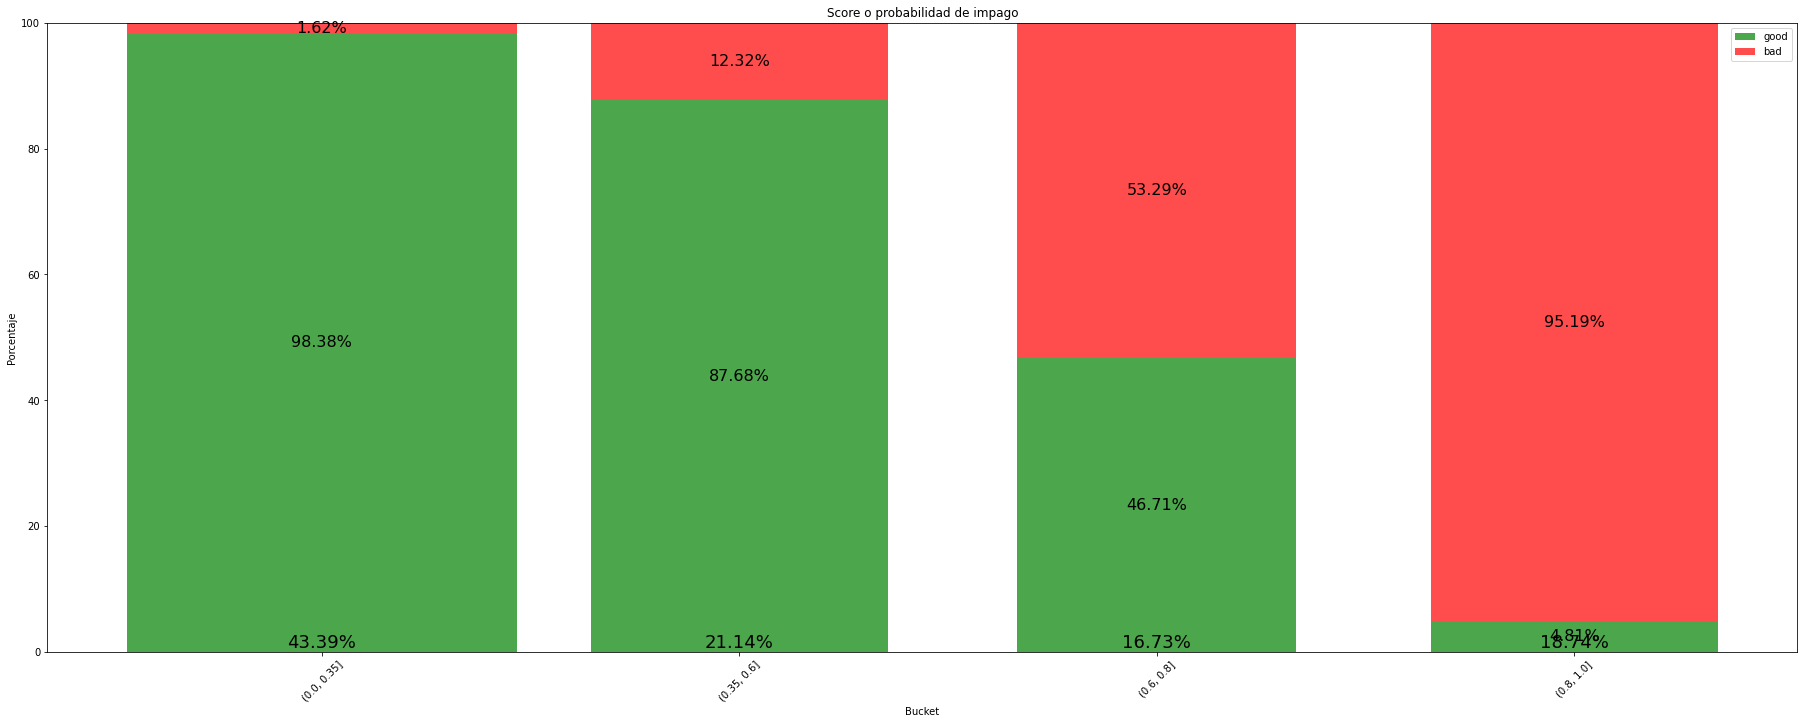

In [105]:
# Definir los buckets
bins = [0,0.35,0.6,0.8,1] 

# Separar la columna en buckets
base_historica['Bucket'] = pd.cut(base_historica['score'], bins)

# Calcular el porcentaje de cada bucket respecto a la población total
bucket_percentage = base_historica['Bucket'].value_counts(normalize=True) * 100
bucket_percentage = bucket_percentage.reindex(pd.cut(base_historica['score'], bins).cat.categories)

# Calcular el porcentaje de cada bucket que pertenece a la class 1 o 0
class_percentage = base_historica.groupby('Bucket')['class'].value_counts(normalize=True).unstack().fillna(0) * 100

# Graficar en una gráfica de barras
bar_width = bucket_percentage / 100
bar_positions = np.arange(len(bucket_percentage))

fig, ax = plt.subplots(figsize=(25,10))


bar_width_total = bar_width + 0.5  # Sumamos 0.5 para separar las barras

bar1 = ax.bar(bar_positions, class_percentage["good"], width=bar_width_total, label='good', color='green', alpha=0.7)
bar2 = ax.bar(bar_positions, class_percentage["bad"], width=bar_width_total, label='bad', color='red', bottom=class_percentage["good"], alpha=0.7)

# Anotar porcentajes de pr2_after_campaing
for i, (bucket, perc) in enumerate(class_percentage.iterrows()):
    if (perc['good']!=0):
        ax.text(i, perc['good'] / 2, f'{perc["good"]:.2f}%', ha='center', va='center', color='black', fontsize=16)
    if (perc['bad']!=0):
        ax.text(i, perc['good'] + perc["bad"] / 2, f'{perc["bad"]:.2f}%', ha='center', va='center', color='black', fontsize=16)
   
# Anotar porcentajes de bucket  
for i, perc in enumerate(bucket_percentage):
    ax.text(i, 0, f'{perc:.2f}%', ha='center', va='bottom', color='black', fontsize=18)

# Ajustar etiquetas y título
ax.set_xlabel('Bucket')
ax.set_ylabel('Porcentaje')
ax.set_title('Score o probabilidad de impago')
ax.set_xticks(bar_positions)
ax.set_xticklabels(bucket_percentage.index, rotation=45)
ax.set_ylim(0,100)
ax.legend()

# Ajustar espaciado entre barras
fig.tight_layout(pad=0.5)

# Mostrar la gráfica
plt.show()

Como podemos ver en la gráfica anterior, si se toman scores de 0 a 0.35 dentro 43.39% de la población que caen en ese bucket el 98.38% pagará, mientras que el 1.62% no. Sin embargo, se puede ver que este % va aumentando conforme nos movemos de bucket. Por lo que se van a definir perfiles de riesgo, los cuales nos permitirán implementar de manera más sencilla un análisis riesgo-crédito.
Se van a clasificar a los clientes como Excelente, Buenos, Regulares, Malos, donde a los excelentes se les aceptará el crédito con tasas de interés más bajas, mientras que a los malos no se les dará el crédito, o se les dará con la tasa más alta y los buenos y regular se les dará una tasa de interés más alta.

In [106]:

def clasificar_cliente(score):
    if score <= 0.35:
        return "Excelente"
    elif score <= 0.6:
        return "Bueno"
    elif score <= 0.8:
        return "Regular"
    else:
        return "Malo"

# Aplicar la función de clasificación al DataFrame
base_historica['Clasificacion_clientes'] = base_historica['score'].apply(clasificar_cliente)

# Verificar si los datos se clasificaron correctamente
print(base_historica.head())


   checking_status  duration  credit_history  purpose  credit_amount  \
0                3         6               4        3           1169   
1                2        48               2        3           5951   
2                0        12               4       10           2096   
3                3        42               2        4           7882   
4                3        24               3        8           4870   

   savings_status  employment  installment_commitment  personal_status  \
0               3           2                       4                1   
1               5           3                       2                3   
2               5           1                       2                1   
3               5           1                       2                1   
4               5           3                       3                1   

   other_parties  ...  housing  existing_credits  job  num_dependents  \
0              2  ...        1                 2 

El siguiente paso será añadir el monto solicitado por cada cliente, en base a estadísticos que se encontraron en España. Lo ideal sería tomar valores reales, pero por ahora no se cuentas con ellos en la base de datos.


In [107]:
base_historica['Monto']= [random.gauss(5000, 3000)for i in range (len(base_historica))]
base_historica['Tasa_recuperacion']=0.6
base_historica['LGD']=0.4
base_historica['Momento_impago']=base_historica['duration']/2

De pendiendo de la duración del préstamo (Duration) se asignará un interés u otro.

Se quiere calcular la pérdida esperada de los clientes PE = PD* LGD *EAD, como lo que se busca el la mejor tasa de interes para poder mminimizar esa pérdida, la EAd se irá calculando progresivamente dentro de los algoritmos genéticos, ya que EAD es 
EAD=Saldo del prestamo+Intereses acumulados

## Función de optimización


In [109]:
!pip install deap

In [110]:
from deap import base, creator, tools, algorithms

Ahora habrá que especificarle al algoritmo lo que queremos que haga, en este caso será minimizar. Se inilializan los pesos en 0, es decir, ninguna variable más importante que otra.

In [111]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

Se calcula una función de pérdida que calcule la pérdida esperada de cada cliente

In [115]:
import random
from deap import base, creator, tools, algorithms
import pandas as pd

# Definición del problema de minimización
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

# Límites para cada categoría
limites = {
    'Excelente': (0.01, 0.05),
    'Bueno': (0.05, 0.1),
    'Regular': (0.1, 0.15),
    'Malo': (0.15, 0.2)
}

# Crear un individuo
toolbox = base.Toolbox()
toolbox.register("attr_float_Excelente", random.uniform, *limites['Excelente'])
toolbox.register("attr_float_Bueno", random.uniform, *limites['Bueno'])
toolbox.register("attr_float_Regular", random.uniform, *limites['Regular'])
toolbox.register("attr_float_Malo", random.uniform, *limites['Malo'])

toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.attr_float_Excelente, toolbox.attr_float_Bueno, toolbox.attr_float_Regular, toolbox.attr_float_Malo), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Definir la función para calcular la pérdida
def calcular_perdida(individual):
    tasa_excelente, tasa_bueno, tasa_regular, tasa_malo = individual
    perdida_total = 0.0

    for index, cliente in base_historica.iterrows():
        monto = cliente['Monto']
        score = cliente['score']
        lgd = cliente['LGD']
        duracion = int(cliente['duration'])
        clasificacion = cliente['Clasificacion_clientes']

        if monto <= 0 or score <= 0 or lgd <= 0 or duracion <= 0:
            continue

        if clasificacion == 'Excelente':
            tasa = tasa_excelente
        elif clasificacion == 'Bueno':
            tasa = tasa_bueno
        elif clasificacion == 'Regular':
            tasa = tasa_regular
        elif clasificacion == 'Malo':
            tasa = tasa_malo
        else:
            continue

        tasa_mensual = tasa / 12
        n = duracion
        p = n / 2
        saldo_pendiente = monto * ((1 + tasa_mensual)**n - (1 + tasa_mensual)**p) / ((1 + tasa_mensual)**n - 1)
        perdida = saldo_pendiente * score * lgd
        perdida_total += perdida

    perdida_total = max(0.0, perdida_total)
    return perdida_total,

toolbox.register("evaluate", calcular_perdida)

# Definir funciones de cruce y mutación con restricción de límites
def cxBlend(ind1, ind2, alpha):
    size = min(len(ind1), len(ind2))
    for i in range(size):
        gamma = (1.0 + 2.0 * alpha) * random.random() - alpha
        ind1[i], ind2[i] = (1.0 - gamma) * ind1[i] + gamma * ind2[i], gamma * ind1[i] + (1.0 - gamma) * ind2[i]

        # Asegurar que los valores estén dentro de los límites
        low, up = limites[list(limites.keys())[i]]
        ind1[i] = max(min(ind1[i], up), low)
        ind2[i] = max(min(ind2[i], up), low)
    return ind1, ind2

def mutPolynomialBounded(individual, eta, low, up, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            x = individual[i]
            delta_q = (x - low[i]) / (up[i] - low[i])
            delta_p = (up[i] - x) / (up[i] - low[i])
            mut_pow = 1.0 / (eta + 1.0)
            rand = random.random()
            if rand < 0.5:
                xy = 1.0 - delta_q
                val = 2.0 * rand + (1.0 - 2.0 * rand) * xy ** (eta + 1.0)
                delta = val ** mut_pow - 1.0
            else:
                xy = 1.0 - delta_p
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * xy ** (eta + 1.0)
                delta = 1.0 - val ** mut_pow

            # Asegurar que el valor mutado sea real y esté dentro de los límites
            x = x + delta * (up[i] - low[i])
            x = max(min(x.real, up[i]), low[i])
            individual[i] = x

    return individual,

toolbox.register("mate", cxBlend, alpha=0.5)
toolbox.register("mutate", mutPolynomialBounded, eta=0.1,
                 low=[limites[l][0] for l in ['Excelente', 'Bueno', 'Regular', 'Malo']],
                 up=[limites[l][1] for l in ['Excelente', 'Bueno', 'Regular', 'Malo']], indpb=0.2)

# Parámetros del algoritmo genético
population = toolbox.population(n=100)
ngen = 50
cxpb = 0.7
mutpb = 0.3

# Ejecutar el algoritmo genético
for gen in range(ngen):
    offspring = algorithms.varAnd(population, toolbox, cxpb, mutpb)

    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit

    population = tools.selBest(offspring, k=len(population))

# Obtener el mejor individuo
best_individual = tools.selBest(population, k=1)[0]
print(f"Mejor solución: {best_individual}")
print(f"Con una pérdida mínima de: {calcular_perdida(best_individual)[0]}")


Mejor solución: [0.012831872261433612, 0.050808083048875644, 0.1, 0.15003806363724598]
Con una pérdida mínima de: 473692.5378557695


In [117]:
suma_columna_B = base_historica['Monto'].sum()
suma_columna_B


4859199.072367196